In [1]:
# Import all required libraries
import re
import numpy as np
import pandas as pd
import math
import random
import tensorflow as tf
from tensorflow.keras import layers
import bert
from transformers import DistilBertTokenizer, RobertaTokenizer, TFRobertaModel,RobertaConfig
from transformers import AutoTokenizer, AutoModel, pipeline, TFDistilBertModel, DistilBertConfig
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader 
from transformers import AdamW, get_linear_schedule_with_warmup
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [3]:
MAX_LEN = 512
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
## Function to clean the data
def clean_data(record):
    # Removing the first few header lines
    record = re.sub(r"Sample Name: .*\n", '', record)
    record = re.sub(r"Description: .*\n", '', record)
    record = re.sub(r"\(Medical Transcription Sample Report\)\n", '', record)
    # Removing additional some special characters, whitespaces and end of lines
    record = re.sub(r"[-:]+", ' ', record)
    record = re.sub(r"\n+", ' ', record)
    record = re.sub(r" +", ' ', record)
    return record

In [6]:
def to_category(rating):
    if rating == 'Blue':
        return 0
    elif rating == 'Green':
        return 1
    elif rating == 'Orange':
        return 2
    elif rating == 'Red':
        return 3
    else:
        return 4

In [7]:
# Reading the data
df = pd.read_csv("clinicalnotes.csv")
df.head

<bound method NDFrame.head of      Record Id Category                                        Description  \
0          101   Yellow  Sample Name: A 5-month-old boy with cough\nDes...   
1          102   Yellow  Sample Name: Abdominal Pain - Consult\nDescrip...   
2          103   Yellow  Sample Name: Abnormal Echocardiogram\nDescript...   
3          104      Red  Sample Name: Abnormal Stress Test\nDescription...   
4          105   Yellow  Sample Name: Abrasions & Lacerations - ER Visi...   
..         ...      ...                                                ...   
511       5202     Blue  Sample Name: Well-Child Check - 7\n\nDescripti...   
512       5203     Blue  Sample Name: Well-woman checkup\n\nDescription...   
513       5204    Green  Sample Name: Worker's Compensation Injury\n\nD...   
514       5205   Yellow  Sample Name: Wound Care Consult\n\nDescription...   
515       5206   Yellow  Sample Name: Wrist Pain\n\nDescription: Consul...   

                                 

In [8]:
category_dummies = pd.get_dummies(df.Category)
new_df = pd.concat([df, category_dummies], axis=1)
new_df['review'] = df.Description.apply(clean_data)
new_df['rating'] = df.Category.apply(to_category)
new_df.head

<bound method NDFrame.head of      Record Id Category                                        Description  \
0          101   Yellow  Sample Name: A 5-month-old boy with cough\nDes...   
1          102   Yellow  Sample Name: Abdominal Pain - Consult\nDescrip...   
2          103   Yellow  Sample Name: Abnormal Echocardiogram\nDescript...   
3          104      Red  Sample Name: Abnormal Stress Test\nDescription...   
4          105   Yellow  Sample Name: Abrasions & Lacerations - ER Visi...   
..         ...      ...                                                ...   
511       5202     Blue  Sample Name: Well-Child Check - 7\n\nDescripti...   
512       5203     Blue  Sample Name: Well-woman checkup\n\nDescription...   
513       5204    Green  Sample Name: Worker's Compensation Injury\n\nD...   
514       5205   Yellow  Sample Name: Wound Care Consult\n\nDescription...   
515       5206   Yellow  Sample Name: Wrist Pain\n\nDescription: Consul...   

                                 

In [9]:
final_df = new_df[['review', 'rating']]

In [10]:
df_train, df_test = train_test_split(
                                  final_df,
                                  test_size=0.2,
                                  random_state=RANDOM_SEED)
df_val, df_test = train_test_split(
                                  df_test,
                                  test_size=0.5,
                                  random_state=RANDOM_SEED)

In [11]:
#Print length of dataset
print(len(df_train))
print(len(df_val))
print(len(df_test))

412
52
52


In [12]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
                                          review,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          return_token_type_ids=False,
                                          pad_to_max_length=True,
                                          return_attention_mask=True,
                                          truncation=True,
                                          return_tensors='pt',
                                        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
          }

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(
                    ds,
                    batch_size=batch_size,
                    num_workers=4)
  

In [14]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
# Checking sample data
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [16]:
class TriageClassifier(nn.Module):

    def __init__(self, n_classes):
        super(TriageClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
                          input_ids=input_ids,
                          attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
no_of_classes = 5
model = TriageClassifier(no_of_classes)
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['bert.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Check example 
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


In [19]:
# Sample prediction
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2174, 0.2555, 0.2094, 0.0931, 0.2246],
        [0.1918, 0.2198, 0.2092, 0.1900, 0.1891],
        [0.2262, 0.1287, 0.2700, 0.1444, 0.2306],
        [0.1304, 0.1265, 0.2323, 0.1803, 0.3304],
        [0.1761, 0.1657, 0.2509, 0.1668, 0.2406],
        [0.2456, 0.2253, 0.1696, 0.1278, 0.2317],
        [0.1806, 0.2641, 0.2291, 0.1187, 0.2075],
        [0.1654, 0.1726, 0.2655, 0.1637, 0.2327],
        [0.1929, 0.1235, 0.2101, 0.2504, 0.2230],
        [0.2388, 0.1409, 0.1675, 0.1444, 0.3084],
        [0.1402, 0.2100, 0.2505, 0.1481, 0.2511],
        [0.1696, 0.1785, 0.2979, 0.1620, 0.1920],
        [0.1543, 0.2483, 0.1789, 0.1171, 0.3015],
        [0.1613, 0.2181, 0.2861, 0.1856, 0.1488],
        [0.2651, 0.2314, 0.2021, 0.1050, 0.1964],
        [0.2056, 0.1883, 0.2109, 0.1263, 0.2690]], grad_fn=<SoftmaxBackward>)

In [20]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
                          optimizer,
                          num_warmup_steps=0,
                          num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
def train_epoch(
                model,
                data_loader,
                loss_fn,
                optimizer,
                device,
                scheduler,
                n_examples):
    model = model.train()
    #print("training examples",n_examples)

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        #print("Target: ",targets)

        outputs = model(input_ids=input_ids,
                      attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        #print("Prediction",preds)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0
    #print("validation examples",n_examples)

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            #print("Target: ",targets)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            #print("Prediction",preds)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            #print(correct_predictions.double())
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
                            model,
                            train_data_loader,
                            loss_fn,
                            optimizer,
                            device,
                            scheduler,
                            len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
                                model,
                                val_data_loader,
                                loss_fn,
                                device,
                                len(df_val)
                                )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.478151486470149 accuracy 0.3058252427184466
Val   loss 1.4035188853740692 accuracy 0.38461538461538464

Epoch 2/10
----------
Train loss 1.269127687582603 accuracy 0.47572815533980584
Val   loss 1.1138008087873459 accuracy 0.5

Epoch 3/10
----------
Train loss 1.1040200430613298 accuracy 0.5364077669902912
Val   loss 1.1490154266357422 accuracy 0.6153846153846154

Epoch 4/10
----------
Train loss 0.8742456573706406 accuracy 0.633495145631068
Val   loss 1.3449214547872543 accuracy 0.5384615384615384

Epoch 5/10
----------
Train loss 0.6594629207482705 accuracy 0.7378640776699029
Val   loss 1.3739869445562363 accuracy 0.6346153846153846

Epoch 6/10
----------
Train loss 0.45774763134809643 accuracy 0.8398058252427184
Val   loss 1.6569649577140808 accuracy 0.5961538461538461

Epoch 7/10
----------
Train loss 0.27609571184103304 accuracy 0.9223300970873787
Val   loss 1.791590616106987 accuracy 0.5384615384615384

Epoch 8/10
----------
Train loss 0.1703228

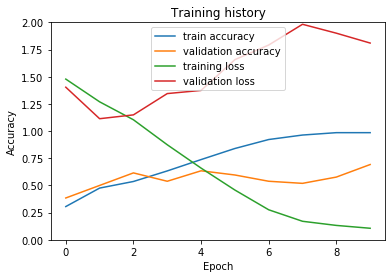

In [27]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

In [28]:
test_acc, _ = eval_model(
                    model,
                    test_data_loader,
                    loss_fn,
                    device,
                    len(df_test)
                    )

print(test_acc.item())

0.6153846153846154


In [30]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [31]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
                                                          model,
                                                          test_data_loader)

In [33]:
class_names=['Blue','Green','Orange','Red','Yellow']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Blue       0.67      0.57      0.62         7
       Green       0.65      0.85      0.74        20
      Orange       0.67      0.29      0.40         7
         Red       1.00      0.67      0.80         3
      Yellow       0.47      0.47      0.47        15

    accuracy                           0.62        52
   macro avg       0.69      0.57      0.60        52
weighted avg       0.62      0.62      0.60        52



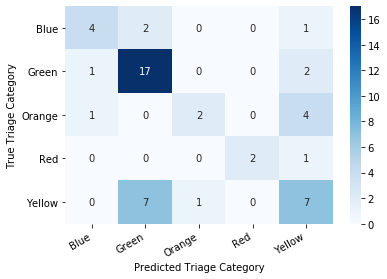

In [38]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Triage Category')
    plt.xlabel('Predicted Triage Category')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)